# Active Learning Guide

TBD.

## Setup

In [260]:
from pathlib import Path

import torch
from torch.utils.data import DataLoader
import torchvision.transforms as T

In [261]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Dataset

In [262]:
IMAGE_MIN_SIZE = 64
TRAIN_RATIO = 0.2
BATCH_SIZE = 64

In [263]:
from data_utils import (
    build_resized_image_folder,
    build_paths_and_labels,
    train_test_val_pool_split,
    CustomDataset,
    IMAGENET_MEAN,
    IMAGENET_STD,
    visualize_batch,
)

In [264]:
# Resize images to 64px their smallest side and save to new folder.
# This will accelerate training, since the purpose is to show how active learning works.
dataset_root = Path("./data/flowers")
build_resized_image_folder(
    src_root=dataset_root / "train",
    dst_root=dataset_root / f"train_{IMAGE_MIN_SIZE}",
    min_side=IMAGE_MIN_SIZE,
    overwrite=False,
)

Processing images: 100%|██████████| 2751/2751 [00:03<00:00, 787.08it/s]

Done. Processed 2746 images. Wrote 0 resized images to: data\flowers\train_64


In [265]:
# Given the root path, get lists of paths and labels
paths, labels, classe_names, class_to_id = build_paths_and_labels(dataset_root / f"train_{IMAGE_MIN_SIZE}")

In [266]:
print(f"Number of paths: {len(paths)}")
print(f"Classes: {classe_names}")
print(f"Class to index mapping: {class_to_id}")
print(f"First path: {paths[0]}")
print(f"First label (int, id): {labels[0]}")
print(f"First label (str): {classe_names[labels[0]]}")

Number of paths: 2746
Classes: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
Class to index mapping: {'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}
First path: data\flowers\train_64\daisy\10140303196_b88d3d6cec.jpg
First label (int, id): 0
First label (str): daisy


In [267]:
# Perform stratified splitsfor train/val/test/pool
# Pool is the portion of the data which is considered "unlabeled" and can be queried for active learning.
train_idx, val_idx, test_idx, pool_idx = train_test_val_pool_split(
    labels, train_ratio=0.2, val_ratio=0.1, test_ratio=0.1, seed=42
)

In [268]:
print(f"Train size: {len(train_idx)}")
print(f"Val size: {len(val_idx)}")
print(f"Test size: {len(test_idx)}")
print(f"Pool size: {len(pool_idx)}")

Train size: 548
Val size: 276
Test size: 276
Pool size: 1646


In [269]:
# Transforms
train_transform = T.Compose([
    T.Resize((IMAGE_MIN_SIZE, IMAGE_MIN_SIZE)),
    T.RandomApply([T.RandomRotation(degrees=15)], p=0.7),
    T.RandomApply([T.RandomAffine(degrees=0, translate=(0.10, 0.10))], p=0.7),
    T.RandomHorizontalFlip(p=0.5),
    T.ToTensor(),
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

eval_transform = T.Compose([
    T.Resize((IMAGE_MIN_SIZE, IMAGE_MIN_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

In [270]:
# Auxiliary factory function to create DataLoaders
# If not Windows, set num_workers > 0 for faster data loading.
# If CUDA is available, set pin_memory=True for faster data transfer to GPU.
def make_loader(ds, batch_size=16, shuffle=False, num_workers=1, pin_memory=False):
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        pin_memory=pin_memory,
        drop_last=False,
    )

In [271]:
# Datasets and loaders
train_ds = CustomDataset(paths, labels, train_idx, transform=train_transform)
val_ds = CustomDataset(paths, labels, val_idx, transform=eval_transform)
test_ds = CustomDataset(paths, labels, test_idx,  transform=eval_transform)
pool_ds = CustomDataset(paths, labels, pool_idx, transform=eval_transform)

train_loader = make_loader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = make_loader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader = make_loader(test_ds, batch_size=BATCH_SIZE, shuffle=False)
pool_loader = make_loader(pool_ds, batch_size=BATCH_SIZE, shuffle=False)

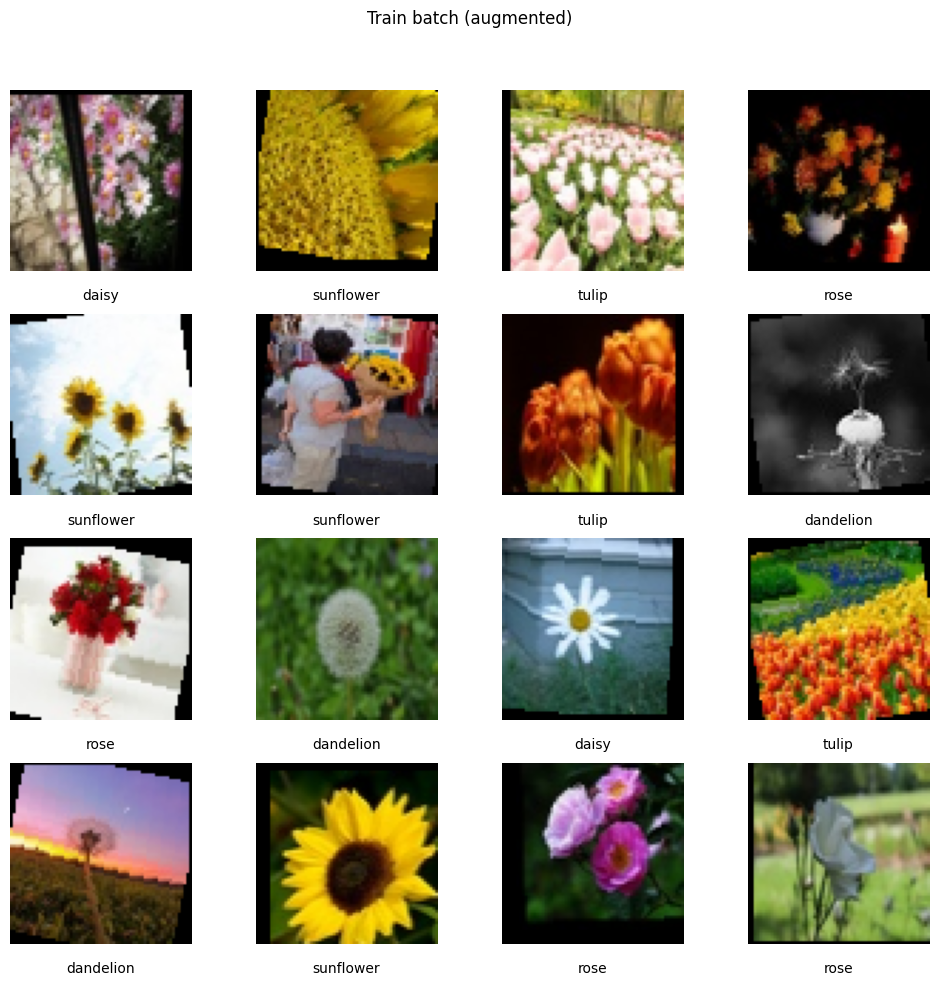

In [272]:
batch = next(iter(train_loader))
visualize_batch(batch, class_names=classe_names, title="Train batch (augmented)")

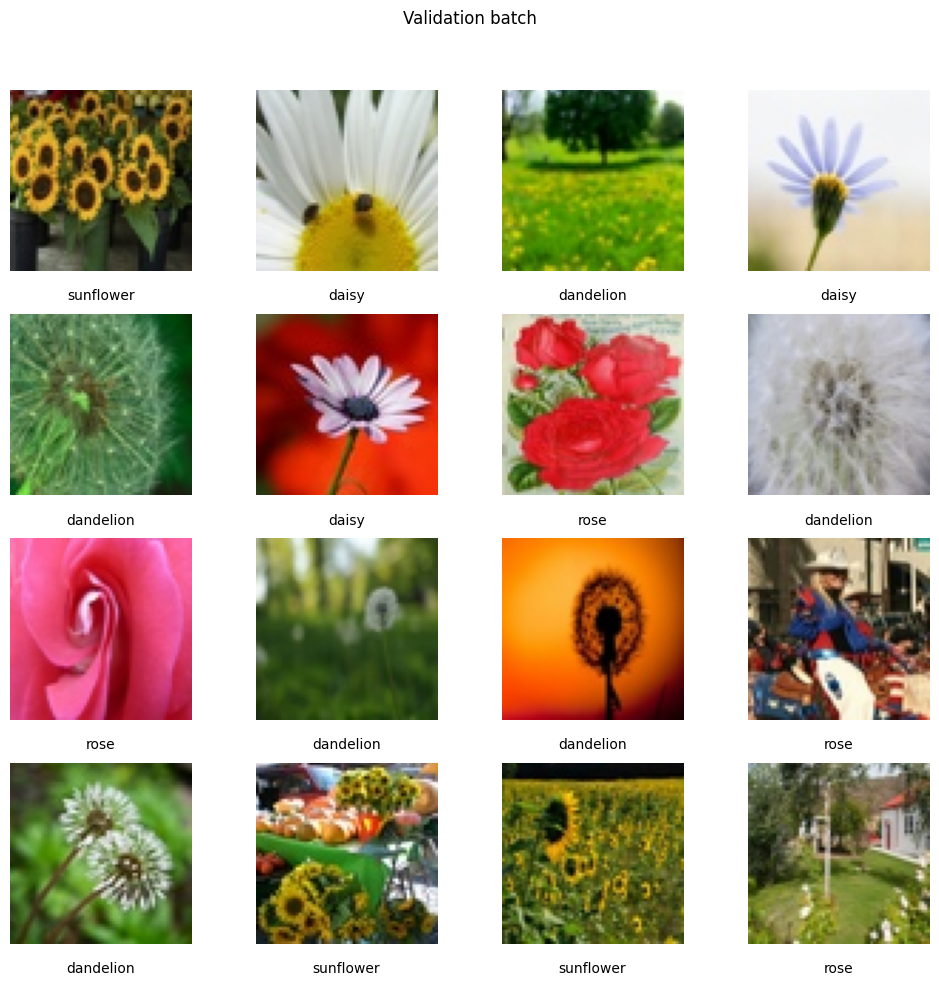

In [273]:
batch = next(iter(val_loader))
visualize_batch(batch, class_names=classe_names, title="Validation batch")

## Model Definition and Training Check

In [314]:
from model_utils import (
    SimpleCNN,
    TrainConfig,
    train,
    evaluate,
    plot_history,
    load_model,
    predict,
    predict_image,
)

In [315]:
# model
model = SimpleCNN(num_classes=len(classe_names))

In [316]:
model

SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (projection): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=8192, out_features=256, bias=T

In [317]:
# Single Pass
batch = next(iter(val_loader))
images, labels = batch
label_names = [classe_names[l] for l in labels]
preds = predict(
    model=model,
    batch=batch,
    device="cpu",
    class_names=classe_names,
)

In [318]:
# Accuracy for the batch
sum([1 if p == l else 0 for p, l in zip(preds, label_names)]) / len(preds)

0.1875

In [319]:
# Check that the classifier / feature vector switch works as expected
model.eval()
with torch.no_grad():
    raw_output = model(images, feature_vector=False)
    print(raw_output.shape)

torch.Size([64, 5])


In [320]:
# Training Configuration
cfg = TrainConfig(
    num_classes=len(classe_names),
    epochs=20,
    lr=1e-3,
    batch_size=BATCH_SIZE,
    out_dir="runs/flowers_cnn",
    run_name=f"train_ratio_{TRAIN_RATIO}",
    metric_for_best="val_f1",  # "val_acc" | "val_loss" | "val_f1"
    maximize_metric=True,
)

In [151]:
# Train the model!
history = train(model, train_loader, val_loader, cfg)

Training epochs:   5%|▌         | 1/20 [00:20<06:26, 20.35s/it]

Epoch 001/20 | train_loss=2.8855 train_acc=0.312 train_f1=0.309 | val_loss=1.5711 val_acc=0.388 val_f1=0.317 | lr=1.00e-03


Training epochs:  10%|█         | 2/20 [00:38<05:38, 18.82s/it]

Epoch 002/20 | train_loss=1.6026 train_acc=0.449 train_f1=0.435 | val_loss=1.3918 val_acc=0.460 val_f1=0.450 | lr=1.00e-03


Training epochs:  15%|█▌        | 3/20 [00:55<05:11, 18.30s/it]

Epoch 003/20 | train_loss=1.3420 train_acc=0.422 train_f1=0.410 | val_loss=1.2602 val_acc=0.467 val_f1=0.448 | lr=1.00e-03


Training epochs:  20%|██        | 4/20 [01:14<04:58, 18.64s/it]

Epoch 004/20 | train_loss=1.2178 train_acc=0.449 train_f1=0.443 | val_loss=1.2289 val_acc=0.489 val_f1=0.490 | lr=1.00e-03


Training epochs:  25%|██▌       | 5/20 [01:34<04:45, 19.02s/it]

Epoch 005/20 | train_loss=1.1634 train_acc=0.502 train_f1=0.490 | val_loss=1.2795 val_acc=0.511 val_f1=0.503 | lr=1.00e-03


Training epochs:  30%|███       | 6/20 [01:52<04:22, 18.78s/it]

Epoch 006/20 | train_loss=1.1437 train_acc=0.522 train_f1=0.510 | val_loss=1.2139 val_acc=0.489 val_f1=0.478 | lr=1.00e-03


Training epochs:  35%|███▌      | 7/20 [02:10<04:00, 18.46s/it]

Epoch 007/20 | train_loss=1.0808 train_acc=0.555 train_f1=0.556 | val_loss=1.1535 val_acc=0.547 val_f1=0.542 | lr=1.00e-03


Training epochs:  40%|████      | 8/20 [02:29<03:41, 18.43s/it]

Epoch 008/20 | train_loss=1.0607 train_acc=0.586 train_f1=0.577 | val_loss=1.1437 val_acc=0.543 val_f1=0.535 | lr=1.00e-03


Training epochs:  45%|████▌     | 9/20 [02:47<03:21, 18.33s/it]

Epoch 009/20 | train_loss=0.9881 train_acc=0.619 train_f1=0.612 | val_loss=1.1595 val_acc=0.514 val_f1=0.505 | lr=1.00e-03


Training epochs:  50%|█████     | 10/20 [03:05<03:03, 18.35s/it]

Epoch 010/20 | train_loss=0.9863 train_acc=0.597 train_f1=0.589 | val_loss=1.1227 val_acc=0.562 val_f1=0.558 | lr=1.00e-03


Training epochs:  55%|█████▌    | 11/20 [03:27<02:53, 19.29s/it]

Epoch 011/20 | train_loss=0.9157 train_acc=0.641 train_f1=0.638 | val_loss=1.1201 val_acc=0.558 val_f1=0.552 | lr=1.00e-03


Training epochs:  60%|██████    | 12/20 [03:48<02:40, 20.03s/it]

Epoch 012/20 | train_loss=0.9338 train_acc=0.595 train_f1=0.588 | val_loss=1.1302 val_acc=0.547 val_f1=0.545 | lr=1.00e-03


Training epochs:  65%|██████▌   | 13/20 [04:10<02:24, 20.62s/it]

Epoch 013/20 | train_loss=0.8843 train_acc=0.657 train_f1=0.655 | val_loss=1.0862 val_acc=0.569 val_f1=0.568 | lr=1.00e-03


Training epochs:  70%|███████   | 14/20 [04:33<02:08, 21.35s/it]

Epoch 014/20 | train_loss=0.8718 train_acc=0.628 train_f1=0.625 | val_loss=1.0456 val_acc=0.565 val_f1=0.554 | lr=1.00e-03


Training epochs:  75%|███████▌  | 15/20 [04:54<01:45, 21.14s/it]

Epoch 015/20 | train_loss=0.8380 train_acc=0.653 train_f1=0.643 | val_loss=1.1456 val_acc=0.543 val_f1=0.532 | lr=1.00e-03


Training epochs:  80%|████████  | 16/20 [05:12<01:21, 20.34s/it]

Epoch 016/20 | train_loss=0.8369 train_acc=0.653 train_f1=0.649 | val_loss=1.1219 val_acc=0.580 val_f1=0.576 | lr=1.00e-03


Training epochs:  85%|████████▌ | 17/20 [05:31<00:59, 19.78s/it]

Epoch 017/20 | train_loss=0.8373 train_acc=0.668 train_f1=0.668 | val_loss=1.1155 val_acc=0.605 val_f1=0.600 | lr=1.00e-03


Training epochs:  90%|█████████ | 18/20 [05:51<00:39, 19.78s/it]

Epoch 018/20 | train_loss=0.7949 train_acc=0.686 train_f1=0.685 | val_loss=1.0432 val_acc=0.598 val_f1=0.593 | lr=1.00e-03


Training epochs:  95%|█████████▌| 19/20 [06:12<00:20, 20.09s/it]

Epoch 019/20 | train_loss=0.7972 train_acc=0.692 train_f1=0.691 | val_loss=1.0168 val_acc=0.605 val_f1=0.586 | lr=1.00e-03


Training epochs: 100%|██████████| 20/20 [06:36<00:00, 19.85s/it]

Epoch 020/20 | train_loss=0.7098 train_acc=0.710 train_f1=0.706 | val_loss=1.0330 val_acc=0.587 val_f1=0.581 | lr=1.00e-03


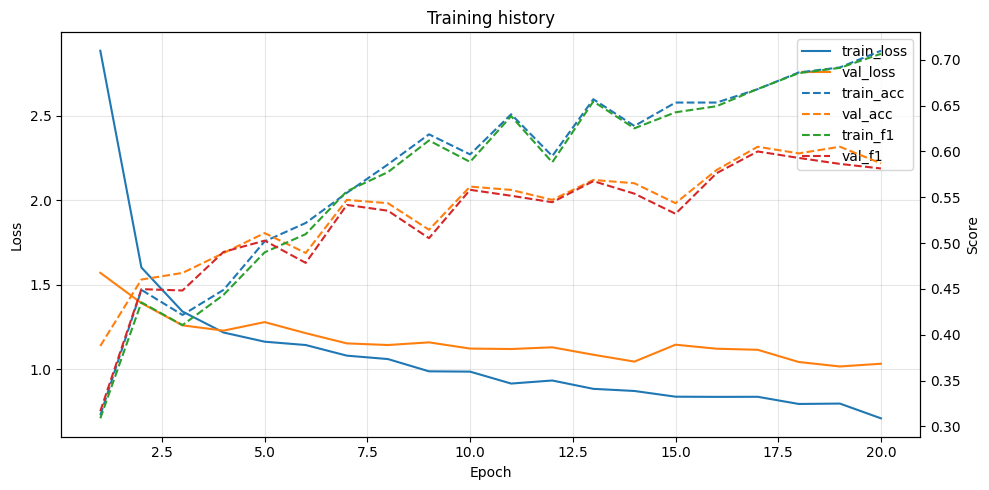

In [152]:
# Plot learning curves
plot_history(history)

In [321]:
# Evaluate best checkpoint
device = torch.device(cfg.device)
ckpt = load_model(Path(cfg.out_dir) / cfg.run_name / "best.pt", model, map_location=cfg.device)
test_metrics = evaluate(model.to(device), test_loader, device, num_classes=len(classe_names))

In [322]:
print(test_metrics)

{'test_loss': 1.0216985318971716, 'test_acc': 0.6521739130434783, 'test_f1': 0.6454928442147929}


In [323]:
# Single Pass
batch = next(iter(val_loader))
images, labels = batch
label_names = [classe_names[l] for l in labels]
preds = predict(
    model=model,
    batch=batch,
    device="cpu",
    class_names=classe_names,
)

In [324]:
# Accuracy for the batch
sum([1 if p == l else 0 for p, l in zip(preds, label_names)]) / len(preds)

0.671875

## Active Learning: Single Query

In [562]:
import numpy as np

from active_ml_utils import (
    TorchClassifierWrapper,
    compute_next_candidates,
    transfer_candidates_idx
)

In [563]:
wrapper = TorchClassifierWrapper(
    model=model,
    pool_ds=pool_ds,
    batch_size=16,  # small for demo
    device="cuda" if torch.cuda.is_available() else "cpu",
    verbose=True,
)

In [564]:
X_small = np.array([[0], [3], [7], [10], [25]])
X_empty = np.empty((0,0))

In [565]:
X_small.shape

(5, 1)

In [566]:
X_empty.shape

(0, 0)

In [567]:
probs = wrapper.predict_proba(X_empty)
feats = wrapper.compute_embeddings(X_empty)

In [568]:
probs = wrapper.predict_proba(X_small)
feats = wrapper.compute_embeddings(X_small)

predict_proba: 100%|██████████| 1/1 [00:00<00:00, 52.61it/s]


In [569]:
print("Shape:", probs.shape)
print("First row probs:", probs[0])
print("First row feats:", feats[0][:20])

Shape: (5, 5)
First row probs: [3.2801325e-03 6.8550222e-03 7.4391090e-04 9.6352673e-01 2.5594257e-02]
First row feats: [0.        0.        0.        0.        0.        0.        0.
 2.4886758 0.        0.        0.        0.        0.        0.
 0.        5.9747047 0.        0.        0.        0.       ]


In [570]:
probs, feats = wrapper.predict_proba(X_small, return_embeddings=True)

predict_proba: 100%|██████████| 1/1 [00:00<00:00, 73.80it/s]


In [571]:
print("Shape:", probs.shape)
print("First row probs:", probs[0])
print("First row feats:", feats[0][:20])

Shape: (5, 5)
First row probs: [3.2801325e-03 6.8550222e-03 7.4391090e-04 9.6352673e-01 2.5594257e-02]
First row feats: [0.        0.        0.        0.        0.        0.        0.
 2.4886758 0.        0.        0.        0.        0.        0.
 0.        5.9747047 0.        0.        0.        0.       ]


In [572]:
len(pool_ds)

1646

In [578]:
candidates_local_idx = compute_next_candidates(
    model=model,
    pool_ds=pool_ds,
    query_size=32,
    method="badge",  # "random", "least_confident", "margin_sampling", "entropy", "badge"
    seed=42,
    batch_size=16,
    device="cpu",
    num_workers=0,
    pin_memory=False,
    verbose=True,
)

predict_proba: 100%|██████████| 103/103 [00:04<00:00, 23.08it/s]


In [579]:
candidates_local_idx

[565,
 957,
 783,
 428,
 154,
 116,
 381,
 1529,
 165,
 313,
 76,
 626,
 881,
 857,
 934,
 433,
 1015,
 1064,
 121,
 1031,
 1273,
 133,
 1264,
 1057,
 1453,
 1549,
 1287,
 1432,
 986,
 86,
 273,
 340]

In [580]:
train_new_idx, pool_new_idx, candidates_global_idx = transfer_candidates_idx(
    train_idx=train_idx,
    pool_idx=pool_idx,
    candidates_idx=candidates_local_idx,
)

In [581]:
candidates_global_idx

[2732,
 1446,
 1614,
 2213,
 1593,
 667,
 2349,
 401,
 543,
 1154,
 2742,
 2689,
 2478,
 2676,
 957,
 2447,
 2389,
 1454,
 2429,
 491,
 1583,
 2085,
 361,
 2291,
 57,
 119,
 1739,
 1332,
 465,
 1470,
 1297,
 1538]

In [582]:
print(f"len(train_idx): {len(train_idx)}")
print(f"len(train_new_idx): {len(train_new_idx)}")

len(train_idx): 548
len(train_new_idx): 580


## Active Learning: Experiments to Compare Strategies